In [41]:
"""
Mount Google Colab Notebook correctly so we are in the correct relative directory
"""
from google.colab import drive
drive.mount('/content/gdrive')
% cd /content/gdrive/My Drive/Github/"CS 499 - SPRING 2022"/"3. Experiments"/"3. COVID_Forecaster"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Github/CS 499 - SPRING 2022/3. Experiments/3. COVID_Forecaster


In [42]:
"""
Ensure we have correct version of Pytorch Geometric before importing or installing anything else
"""
# Code in this cell is courtesy of: https://gist.github.com/ameya98/b193856171d11d37ada46458f60e73e7 
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch
import os

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 
!pip install torch-geometric-temporal # added for GConvGRU
!pip install ogb

print("PyTorch has version {}".format(torch.__version__))

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
PyTorch has version 1.10.0+cu111


In [43]:
"""
Import any other libraries we will use later on
"""
! pip install epiweeks
! pip install haversine
# from preprocess_data import get_preprocessed_data
from torch_geometric.data import Data

In [44]:
"""
Set device (CPU or GPU)
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [45]:
"""
Get preprocessed data
"""

import pickle

# # Get preprocessed data and unpackage variables needed during training/testing/validation
# preprocessed_data = get_preprocessed_data()
# # Save preprocessed data as pickle so we don't have to consecutively re-download the same data (time consuming) when re-running all cells in this notebook
# with open('./data/preprocessed_data.pickle', 'wb') as handle:
#     pickle.dump(preprocessed_data, handle)


# Load in saved preprocessed_data
preprocessed_data = None
with open('./data/preprocessed_data_reorder_input.pickle', 'rb') as handle:
    preprocessed_data = pickle.load(handle)





In [46]:
"""
Unpack preprocessed data
"""
training_variables = preprocessed_data['training_variables']
validation_variables = preprocessed_data['validation_variables']
testing_variables = preprocessed_data['testing_variables']

edge_index = preprocessed_data['edge_index']

train_x = training_variables['train_x_smoothed']
train_y = training_variables['train_y_change_in_confirmed_smoothed']

val_x = validation_variables['val_x_smoothed']
val_y = validation_variables['val_y_change_in_confirmed_smoothed']

test_x = testing_variables['test_x_smoothed']
test_y = testing_variables['test_y_change_in_confirmed_smoothed']

In [47]:
"""
Put preprocessed data into "Data" objects and put "Data" objects into tensors on the "device"
"""
training_data = []
validation_data = []
testing_data = []
for i in range(len(train_x)):
  toAppend = Data(x=train_x[i], y=train_y[i], edge_index=edge_index).to(device)
  training_data.append(toAppend)
for i in range(len(val_x)):
  toAppend = Data(x=val_x[i], y=val_y[i], edge_index=edge_index).to(device)
  validation_data.append(toAppend)
for i in range(len(test_x)):
  toAppend = Data(x=test_x[i], y=test_y[i], edge_index=edge_index).to(device)
  testing_data.append(toAppend)

In [77]:
"""
Define network architecture, optimizer, and loss function
"""
# Reference: https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html 
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv 
from torch_geometric_temporal.nn.recurrent import GConvGRU

inputLayer_num_features = 24 
hiddenLayer1_num_features = 24
hiddenLayer2_num_features = 24
outputLayer_num_features = 15 # pred_window
chebyshev_filter_size = 2
history_window = 6 # history_window

class GCN(torch.nn.Module):
    # def __init__(self):
    #     super().__init__()
    #     self.conv1 = GCNConv(inputLayer_num_features, hiddenLayer1_num_features)
    #     self.conv2 = GCNConv(hiddenLayer1_num_features, outputLayer_num_features)

    def __init__(self):
      super().__init__()
      self.conv1 = GConvGRU(in_channels=inputLayer_num_features, out_channels=hiddenLayer1_num_features, K=chebyshev_filter_size)
      self.conv2 = GConvGRU(in_channels=hiddenLayer1_num_features, out_channels=hiddenLayer2_num_features, K=chebyshev_filter_size)
      self.linear1 = Linear(hiddenLayer2_num_features, outputLayer_num_features)
      self.linear2 = Linear(history_window, outputLayer_num_features)
      self.linear3 = Linear(outputLayer_num_features, outputLayer_num_features)

    # def forward(self, data):
    #     x, edge_index = data.x, data.edge_index
    #     x = self.conv1(x, edge_index)
    #     x = F.elu(x)
    #     x = self.conv2(x, edge_index)
    #     # print(x.shape)
    #     return x

    def forward(self, data):
      x, edge_index = data.x, data.edge_index
      x = self.conv1(x, edge_index)
      x = F.elu(x)
      x = self.conv2(x, edge_index)
      x = F.elu(x)
      x = self.linear1(x) + self.linear2(data.x[:, history_window:history_window+history_window])

      x = F.elu(x)
      x = self.linear3(x)

      return x

model = GCN().to(device)

""" Without extra 3rd linear layer
==================================================================
Saved best model
Epoch 6, Loss 133206572.76, Val loss 11004514.00
"""

""" With extra 3rd linear layer (current)
==================================================================
Saved best model
Epoch 101, Loss 105890643.54, Val loss 11523210.00
"""
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = torch.nn.MSELoss()

SyntaxError: ignored

In [49]:
model

GCN(
  (conv1): GConvGRU(
    (conv_x_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_h): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_h): ChebConv(24, 24, K=2, normalization=sym)
  )
  (conv2): GConvGRU(
    (conv_x_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_h): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_h): ChebConv(24, 24, K=2, normalization=sym)
  )
  (linear1): Linear(in_features=24, out_features=15, bias=True)
  (linear2): Linear(in_features=6, out_features=15, bias=True)
  (linear3): Linear(in_features=15, out_features=15, bias=True)
)

In [50]:
"""
Training
"""
model_path = './saved_models/smoothed_adam_reordered_input_skip_connection'
min_loss = 1e20

def train():
  total_loss = 0.0
  for data in training_data:
    model.train()
    optimizer.zero_grad()
    predicted_output = model(data)
    labeled_output = data.y.to(device)
    loss = criterion(predicted_output, labeled_output)
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
  return total_loss

def validation():
  model.eval()
  totalLoss = 0.0
  for data_validation in validation_data:
    validation_prediction_output = model(data_validation)
    labeled_validation_output = data_validation.y.to(device)
    loss = criterion(validation_prediction_output, labeled_validation_output)
    totalLoss += loss.item()
  return totalLoss

for epoch in range(1000):
  training_loss = train()
  val_loss = validation()
  if val_loss < min_loss:
    min_loss = val_loss
    state = {
        'state': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, model_path)
    print("==================================================================")
    print("Saved best model")
  print('Epoch %d, Loss %.2f, Val loss %.2f'%(epoch, training_loss, val_loss))

Saved best model
Epoch 0, Loss 189441365.02, Val loss 11969130.00
Saved best model
Epoch 1, Loss 159948958.42, Val loss 11940093.00
Epoch 2, Loss 153886461.08, Val loss 11941862.00
Epoch 3, Loss 150233555.31, Val loss 12196999.00
Epoch 4, Loss 146985946.61, Val loss 12056352.00
Saved best model
Epoch 5, Loss 148836621.79, Val loss 11790318.00
Saved best model
Epoch 6, Loss 153755033.36, Val loss 11627850.00
Epoch 7, Loss 156011501.89, Val loss 11691777.00
Epoch 8, Loss 154881435.16, Val loss 11737294.00
Epoch 9, Loss 153764373.66, Val loss 11787668.00
Epoch 10, Loss 148337829.32, Val loss 11840034.00
Epoch 11, Loss 145498014.62, Val loss 11880841.00
Epoch 12, Loss 144526684.64, Val loss 11881245.00
Epoch 13, Loss 141814933.36, Val loss 11892242.00
Epoch 14, Loss 134354459.01, Val loss 11662259.00
Epoch 15, Loss 136265654.86, Val loss 11939390.00
Epoch 16, Loss 135397105.48, Val loss 11882602.00
Epoch 17, Loss 132594610.70, Val loss 11739034.00
Epoch 18, Loss 121384308.57, Val loss 1840

KeyboardInterrupt: ignored

60889476.0
tensor([25569.5137, 25924.6211, 26642.3105, 27422.2227, 28232.3848, 27960.5020,
        28128.3281, 27330.2578, 26957.2402, 27018.3535, 26384.7344, 26255.5566,
        25830.8105, 25891.2598, 25394.2617], grad_fn=<SelectBackward0>)
tensor([25702.3750, 27233.1250, 27508.5000, 28505.2500, 28370.7500, 27967.6250,
        27319.6250, 27271.6250, 26154.2500, 24480.0000, 23189.3750, 21616.0000,
        20695.5000, 19639.2500, 18380.5000])


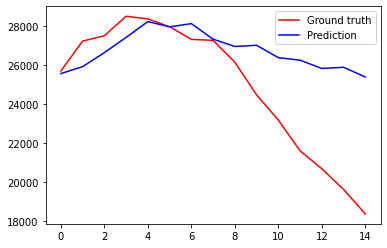

In [76]:
"""
Testing and plotting results
"""
import matplotlib.pyplot as plt

predicted_output = None
labeled_output = None
for data in testing_data:
  model.eval()
  predicted_output = model(data)
  labeled_output = data.y.to(device)
  loss = criterion(predicted_output, labeled_output)
  print(loss.item())

state_num = 38

print(predicted_output[state_num])
print(labeled_output[state_num])

plt.plot(labeled_output[state_num].cpu().detach().numpy(),c='r', label='Ground truth')
plt.plot(predicted_output[state_num].cpu().detach().numpy(),c='b', label='Prediction')
plt.legend()
plt.show()